In [6]:
import lmdb
import pickle
from tqdm import tqdm
import os

def filter_reindex_adsorbate(src_path, dst_path):
    # 1. 타겟 정의
    target_O = [8]
    target_OOH = [1, 8, 8]

    # 출력 경로 폴더 생성
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)

    # 2. LMDB 환경 설정
    # 3GB 설정
    map_size_3gb = 3 * 1024 * 1024 * 1024
    
    # 원본 열기 (읽기 전용)
    env_src = lmdb.open(
        src_path, 
        subdir=False,
        readonly=True, 
        lock=False, 
        readahead=False, 
        meminit=False
    )
    
    # 새 파일 열기 (쓰기용, subdir=False로 단일 파일 생성)
    env_dst = lmdb.open(
        dst_path, 
        map_size=map_size_3gb,
        subdir=False, 
        readonly=False, 
        meminit=False, 
        map_async=True
    )

    print(f"Filtering from: {src_path}")
    print(f"Saving to: {dst_path} (Indices reset from 0)")

    # 원본 키를 기록할 리스트 (추적용)
    # 형식: (새로운인덱스, 원본인덱스) 튜플로 저장하거나 그냥 원본 키만 저장
    keys_O_original = []
    keys_OOH_original = []
    
    # 새로운 인덱스 카운터 (0부터 시작)
    new_index_counter = 0

    with env_src.begin(write=False) as txn_src:
        with env_dst.begin(write=True) as txn_dst:
            cursor = txn_src.cursor()
            total_entries = env_src.stat()['entries']
            
            for key, value in tqdm(cursor, total=total_entries, desc="Processing"):
                try:
                    # 데이터 로드
                    data = pickle.loads(value)
                    
                    if "ads_atomic_numbers" not in data:
                        continue
                        
                    ads_nums = data["ads_atomic_numbers"]
                    
                    # list 변환 및 정렬
                    if hasattr(ads_nums, 'tolist'):
                        ads_list = ads_nums.tolist()
                    else:
                        ads_list = list(ads_nums)
                    
                    sorted_nums = sorted(ads_list)
                    
                    # 원본 키 디코딩 (기록용)
                    original_key_str = key.decode('ascii')
                    
                    match_found = False
                    is_O = False
                    
                    # 조건 확인
                    if sorted_nums == target_O:
                        match_found = True
                        is_O = True
                    elif sorted_nums == target_OOH:
                        match_found = True
                        is_O = False # OOH
                    
                    if match_found:
                        # ---------------------------------------------------------
                        # [핵심 변경 사항] 키를 0부터 다시 매기기
                        # ---------------------------------------------------------
                        new_key = str(new_index_counter).encode('ascii')
                        
                        # 데이터 저장 (내용인 value는 원본 그대로)
                        txn_dst.put(new_key, value)
                        
                        # 원본 키 기록 (Traceback용)
                        # "새로운인덱스: 원본키" 형식으로 저장하면 나중에 매칭하기 좋습니다.
                        log_entry = f"New_{new_index_counter}: Original_{original_key_str}"
                        
                        if is_O:
                            keys_O_original.append(log_entry)
                        else:
                            keys_OOH_original.append(log_entry)
                            
                        # 카운터 증가
                        new_index_counter += 1
                        
                except Exception as e:
                    print(f"Error processing key {key}: {e}")
                    continue

    env_src.close()
    env_dst.close()

    print("\n" + "="*30)
    print("       Filtering Summary       ")
    print("="*30)
    print(f"Total samples saved: {new_index_counter}")
    print(f"Last Index: {new_index_counter - 1}")
    print(f"Count of O samples: {len(keys_O_original)}")
    print(f"Count of OOH samples: {len(keys_OOH_original)}")
    
    # 3. 매핑 정보 파일 저장
    
    # O 샘플 매핑 정보 저장
    with open("mapping_O.txt", "w") as f:
        f.write("\n".join(keys_O_original))
    print(f"\nSaved O mapping to 'mapping_O.txt'")

    # OOH 샘플 매핑 정보 저장
    with open("mapping_OOH.txt", "w") as f:
        f.write("\n".join(keys_OOH_original))
    print(f"Saved OOH mapping to 'mapping_OOH.txt'")

if __name__ == "__main__":
    source_lmdb = "dataset/val_id/dataset.lmdb"
    new_lmdb = "dataset/val_id/2eORR.lmdb"
    
    filter_reindex_adsorbate(source_lmdb, new_lmdb)


Filtering from: dataset/val_id/dataset.lmdb
Saving to: dataset/val_id/2eORR.lmdb (Indices reset from 0)


Processing:  15%|█▌        | 3853/24898 [00:00<00:00, 38448.91it/s]

Processing: 100%|██████████| 24898/24898 [00:00<00:00, 49646.60it/s]

Error processing key b'length': argument of type 'int' is not iterable

       Filtering Summary       
Total samples saved: 622
Last Index: 621
Count of O samples: 622
Count of OOH samples: 0

Saved O mapping to 'mapping_O.txt'
Saved OOH mapping to 'mapping_OOH.txt'


In [9]:
import lmdb
import pickle
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_adsorbate_types(lmdb_path):
    """
    LMDB 데이터셋에서 모든 adsorbate types를 분석하고 통계를 생성합니다.
    
    Args:
        lmdb_path: 분석할 LMDB 파일 경로
    
    Returns:
        adsorbate_dict: {adsorbate_type: [indices]} 형태의 딕셔너리
        count_dict: {adsorbate_type: count} 형태의 딕셔너리
    """
    # 원본 열기 (읽기 전용)
    env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False
    )
    
    # adsorbate type별로 인덱스를 저장할 딕셔너리
    # key: 정렬된 atomic numbers를 튜플로 변환 (딕셔너리 키로 사용하기 위해)
    # value: 해당 adsorbate type을 가진 샘플의 인덱스 리스트
    adsorbate_dict = defaultdict(list)
    
    print(f"Analyzing adsorbate types from: {lmdb_path}")
    
    with env.begin(write=False) as txn:
        cursor = txn.cursor()
        total_entries = env.stat()['entries']
        
        for key, value in tqdm(cursor, total=total_entries, desc="Processing"):
            try:
                # 데이터 로드
                data = pickle.loads(value)
                
                if "ads_atomic_numbers" not in data:
                    continue
                
                ads_nums = data["ads_atomic_numbers"]
                
                # list 변환 및 정렬
                if hasattr(ads_nums, 'tolist'):
                    ads_list = ads_nums.tolist()
                else:
                    ads_list = list(ads_nums)
                
                sorted_nums = sorted(ads_list)
                
                # 튜플로 변환 (딕셔너리 키로 사용하기 위해)
                adsorbate_key = tuple(sorted_nums)
                
                # 원본 키를 인덱스로 변환 (숫자로 변환 가능한 경우)
                try:
                    index = int(key.decode('ascii'))
                except (ValueError, UnicodeDecodeError):
                    # 키가 숫자가 아닌 경우, 원본 키 문자열을 사용
                    index = key.decode('ascii')
                
                # 해당 adsorbate type에 인덱스 추가
                adsorbate_dict[adsorbate_key].append(index)
                
            except Exception as e:
                print(f"Error processing key {key}: {e}")
                continue
    
    env.close()
    
    # atomic numbers를 문자열로 변환하여 읽기 쉽게 만들기
    # 예: (1, 8, 8) -> "H-O-O" 또는 "OOH"
    def get_adsorbate_name(atomic_nums):
        """원자 번호 리스트를 adsorbate 이름으로 변환"""
        # 원자 번호 -> 원소 기호 매핑
        element_map = {
            1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O',
            9: 'F', 10: 'Ne', 11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P',
            16: 'S', 17: 'Cl', 18: 'Ar'
        }
        
        # 원자 번호를 원소 기호로 변환
        elements = [element_map.get(num, f"X{num}") for num in atomic_nums]
        
        # 일반적인 adsorbate 이름 매핑
        common_names = {
            (8,): 'O',
            (1, 8): 'OH',
            (1, 8, 8): 'OOH',
            (1, 1, 8): 'H2O',
            (6, 8): 'CO',
            (6, 8, 8): 'CO2',
        }
        
        if tuple(atomic_nums) in common_names:
            return common_names[tuple(atomic_nums)]
        else:
            return '-'.join(elements)
    
    # 딕셔너리를 이름 기반으로 변환
    named_dict = {}
    for atomic_nums_tuple, indices in adsorbate_dict.items():
        name = get_adsorbate_name(list(atomic_nums_tuple))
        named_dict[name] = sorted(indices)  # 인덱스를 정렬하여 저장
    
    # 개수 계산
    count_dict = {name: len(indices) for name, indices in named_dict.items()}
    
    return named_dict, count_dict

# 분석 실행
source_lmdb = "dataset/val_id/dataset.lmdb"
adsorbate_dict, count_dict = analyze_adsorbate_types(source_lmdb)

print("\n" + "="*50)
print("       Adsorbate Types Analysis       ")
print("="*50)
print(f"Total unique adsorbate types: {len(count_dict)}")
print("\nAdsorbate type counts:")
for name, count in sorted(count_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name}: {count} samples")

Analyzing adsorbate types from: dataset/val_id/dataset.lmdb


Processing: 100%|██████████| 24898/24898 [00:00<00:00, 45537.30it/s]

Error processing key b'length': argument of type 'int' is not iterable

       Adsorbate Types Analysis       
Total unique adsorbate types: 46

Adsorbate type counts:
  H-H-H-H-C-C-O: 1272 samples
  H-H-C-C-O-O: 1226 samples
  H-H-C-C-O: 1207 samples
  H-H-H-H-C-C-O-O: 1207 samples
  H-H-H-H-H-C-C-O: 1094 samples
  H-H-H-C-C-O: 1071 samples
  H-H-H-C-C: 855 samples
  H-H-C-C: 807 samples
  H-H-C-O: 791 samples
  H-H-H-C-O: 732 samples
  H-C-C-O: 652 samples
  O: 622 samples
  H: 608 samples
  C: 597 samples
  H-H-H-C-C-O-O: 581 samples
  N: 573 samples
  H-H-C: 525 samples
  OH: 493 samples
  H-N: 469 samples
  C-C: 461 samples
  H-H-H-C: 437 samples
  H2O: 427 samples
  N-O: 411 samples
  H-N-O: 408 samples
  H-H-H-N: 398 samples
  N-O-O: 396 samples
  H-H-N-N: 383 samples
  H-H-H-H-H-C-C: 375 samples
  N-O-O-O: 367 samples
  H-H-H-H-C: 362 samples
  H-N-N: 359 samples
  N-N-O: 356 samples
  H-C-C-O-O: 353 samples
  H-H-H-N-O: 352 samples
  H-H-H-H-C-O: 345 samples
  H-C-C: 339 sampl

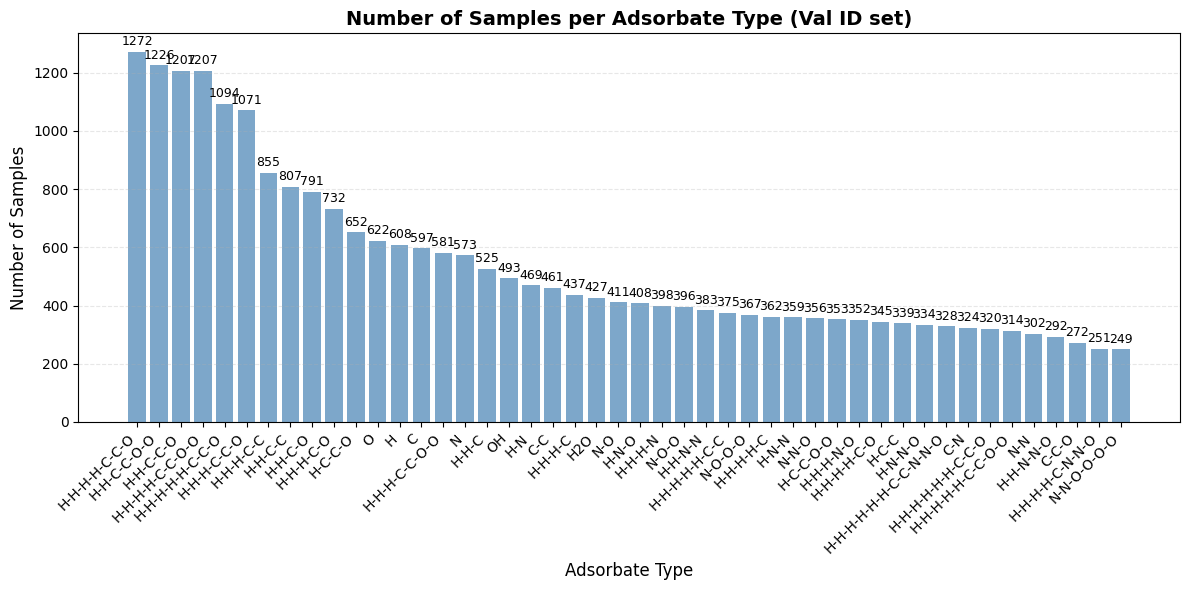


Total samples: 24897
Most common adsorbate: H-H-H-H-C-C-O (1272 samples)
Least common adsorbate: N-N-O-O-O-O (249 samples)


In [10]:
# 2. 각 adsorbate 종류별 샘플 개수를 정렬해서 plot 그리기
import matplotlib.pyplot as plt
import numpy as np

# 개수 기준으로 정렬
sorted_items = sorted(count_dict.items(), key=lambda x: x[1], reverse=True)
adsorbate_names = [item[0] for item in sorted_items]
counts = [item[1] for item in sorted_items]

# Plot 생성
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(adsorbate_names)), counts, color='steelblue', alpha=0.7)
plt.xlabel('Adsorbate Type', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Number of Samples per Adsorbate Type (Val ID set)', fontsize=14, fontweight='bold')
plt.xticks(range(len(adsorbate_names)), adsorbate_names, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# 각 막대 위에 개수 표시
for i, (bar, count) in enumerate(zip(bars, counts)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
             str(count), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nTotal samples: {sum(counts)}")
print(f"Most common adsorbate: {adsorbate_names[0]} ({counts[0]} samples)")
print(f"Least common adsorbate: {adsorbate_names[-1]} ({counts[-1]} samples)")

In [11]:
# 3. 각 adsorbate 종류별 샘플 인덱스를 JSON 파일에 저장
output_json_path = "val_id_adsorbate_indices.json"

# JSON 파일로 저장 (인덱스는 리스트로 저장)
with open(output_json_path, 'w') as f:
    json.dump(adsorbate_dict, f, indent=2)

print(f"Saved adsorbate indices to '{output_json_path}'")
print(f"\nExample entries:")
# 처음 몇 개만 예시로 출력
for i, (name, indices) in enumerate(sorted(adsorbate_dict.items(), key=lambda x: len(x[1]), reverse=True)[:5]):
    print(f"  {name}: {len(indices)} samples, first 10 indices: {indices[:10]}")

Saved adsorbate indices to 'val_id_adsorbate_indices.json'

Example entries:
  H-H-H-H-C-C-O: 1272 samples, first 10 indices: [10, 33, 71, 77, 90, 93, 104, 112, 121, 189]
  H-H-C-C-O-O: 1226 samples, first 10 indices: [44, 50, 53, 58, 59, 87, 108, 171, 202, 204]
  H-H-C-C-O: 1207 samples, first 10 indices: [8, 17, 34, 69, 70, 101, 105, 116, 168, 183]
  H-H-H-H-C-C-O-O: 1207 samples, first 10 indices: [5, 21, 28, 52, 73, 95, 107, 120, 126, 141]
  H-H-H-H-H-C-C-O: 1094 samples, first 10 indices: [47, 51, 56, 67, 100, 152, 211, 227, 248, 255]


In [1]:
import lmdb
import pickle
from tqdm import tqdm

def count_samples_with_helium(lmdb_path):
    """
    LMDB 데이터셋에서 primitive_slab의 get_atomic_numbers()에 
    원자 번호 2(헬륨)가 포함된 샘플의 개수를 세는 함수
    
    Args:
        lmdb_path: 분석할 LMDB 파일 경로
    
    Returns:
        count: 헬륨이 포함된 샘플 개수
        sample_indices: 헬륨이 포함된 샘플의 인덱스 리스트
    """
    # 원본 열기 (읽기 전용)
    env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False
    )
    
    count = 0
    sample_indices = []
    
    print(f"Analyzing primitive_slab from: {lmdb_path}")
    
    with env.begin(write=False) as txn:
        cursor = txn.cursor()
        total_entries = env.stat()['entries']
        
        for key, value in tqdm(cursor, total=total_entries, desc="Processing"):
            try:
                # 데이터 로드
                data = pickle.loads(value)
                
                # primitive_slab이 있는지 확인
                if "primitive_slab" not in data:
                    continue
                
                primitive_slab = data["primitive_slab"]
                
                # get_atomic_numbers() 메서드 호출
                if hasattr(primitive_slab, 'get_atomic_numbers'):
                    atomic_numbers = primitive_slab.get_atomic_numbers()
                else:
                    # 메서드가 없는 경우 다른 속성 확인
                    if hasattr(primitive_slab, 'numbers'):
                        atomic_numbers = primitive_slab.numbers
                    elif hasattr(primitive_slab, 'atomic_numbers'):
                        atomic_numbers = primitive_slab.atomic_numbers
                    else:
                        continue
                
                # numpy array나 list로 변환
                if hasattr(atomic_numbers, 'tolist'):
                    atomic_numbers_list = atomic_numbers.tolist()
                elif hasattr(atomic_numbers, '__iter__'):
                    atomic_numbers_list = list(atomic_numbers)
                else:
                    continue
                
                # 원자 번호 2(헬륨)가 포함되어 있는지 확인
                if 8 in atomic_numbers_list:
                    count += 1
                    
                    # 샘플 인덱스 저장
                    try:
                        index = int(key.decode('ascii'))
                    except (ValueError, UnicodeDecodeError):
                        index = key.decode('ascii')
                    sample_indices.append(index)
                
            except Exception as e:
                print(f"Error processing key {key}: {e}")
                continue
    
    env.close()
    
    return count, sample_indices

# 분석 실행
train_lmdb_path = "dataset/train/dataset.lmdb"
helium_count, helium_indices = count_samples_with_helium(train_lmdb_path)

print("\n" + "="*50)
print("       Helium Analysis Results       ")
print("="*50)
print(f"Total samples with Helium (atomic number 2): {helium_count}")
print(f"Sample indices (first 20): {helium_indices[:20]}")
if len(helium_indices) > 20:
    print(f"... and {len(helium_indices) - 20} more")

Analyzing primitive_slab from: dataset/train/dataset.lmdb


Processing: 100%|██████████| 459440/459440 [00:09<00:00, 49797.63it/s]

Error processing key b'length': argument of type 'int' is not iterable

       Helium Analysis Results       
Total samples with Helium (atomic number 2): 0
Sample indices (first 20): []


In [13]:
import lmdb
import pickle
from tqdm import tqdm
import json
import os

def split_dataset_by_adsorbate(src_lmdb_path, json_path, output_dir):
    """
    JSON 파일에 있는 adsorbate별 인덱스 정보를 이용해서
    원본 LMDB 데이터셋을 adsorbate별로 분리하여 저장합니다.
    
    Args:
        src_lmdb_path: 원본 LMDB 파일 경로
        json_path: adsorbate별 인덱스가 담긴 JSON 파일 경로
        output_dir: 출력 디렉토리 경로
    """
    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)
    
    # JSON 파일 로드
    print(f"Loading adsorbate indices from: {json_path}")
    with open(json_path, 'r') as f:
        adsorbate_indices = json.load(f)
    
    print(f"Found {len(adsorbate_indices)} adsorbate types")
    
    # 원본 LMDB 열기 (읽기 전용)
    env_src = lmdb.open(
        src_lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False
    )
    
    # LMDB map_size 설정 (3GB)
    map_size_3gb = 3 * 1024 * 1024 * 1024
    
    # 각 adsorbate별로 처리
    for adsorbate_name, indices in adsorbate_indices.items():
        if not indices:  # 빈 리스트인 경우 스킵
            continue
        
        # 파일명 생성 (예: train_H-N_subset.lmdb)
        # adsorbate 이름에 특수문자가 있을 수 있으므로 안전하게 처리
        safe_name = adsorbate_name.replace('/', '_').replace('\\', '_')
        output_filename = f"val_id_{safe_name}_subset.lmdb"
        output_path = os.path.join(output_dir, output_filename)
        
        print(f"\nProcessing {adsorbate_name}: {len(indices)} samples")
        print(f"  Saving to: {output_path}")
        
        # 새 LMDB 파일 열기
        env_dst = lmdb.open(
            output_path,
            map_size=map_size_3gb,
            subdir=False,
            readonly=False,
            meminit=False,
            map_async=True
        )
        
        new_index_counter = 0
        
        with env_src.begin(write=False) as txn_src:
            with env_dst.begin(write=True) as txn_dst:
                # 인덱스 리스트를 정렬하여 순차적으로 처리 (더 효율적)
                sorted_indices = sorted(indices)
                
                for original_index in tqdm(sorted_indices, desc=f"  Processing {adsorbate_name}"):
                    try:
                        # 인덱스를 키로 변환
                        key = str(original_index).encode('ascii')
                        
                        # 원본 LMDB에서 데이터 읽기
                        value = txn_src.get(key)
                        
                        if value is None:
                            print(f"  Warning: Index {original_index} not found in source LMDB")
                            continue
                        
                        # 새로운 인덱스로 저장 (0부터 시작)
                        new_key = str(new_index_counter).encode('ascii')
                        txn_dst.put(new_key, value)
                        new_index_counter += 1
                            
                    except Exception as e:
                        print(f"  Error processing index {original_index}: {e}")
                        continue
        
        env_dst.close()
        
        print(f"  Saved {new_index_counter} samples to {output_filename}")
    
    env_src.close()
    
    print("\n" + "="*50)
    print("       Splitting Complete       ")
    print("="*50)
    print(f"All adsorbate subsets saved to: {output_dir}")

# 실행
source_lmdb = "dataset/val_id/dataset.lmdb"
json_file = "val_id_adsorbate_indices.json"
output_directory = "dataset_per_adsorbate"

split_dataset_by_adsorbate(source_lmdb, json_file, output_directory)

Loading adsorbate indices from: val_id_adsorbate_indices.json
Found 46 adsorbate types

Processing H-H-N-N: 383 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-N-N_subset.lmdb


  Processing H-H-N-N: 100%|██████████| 383/383 [00:00<00:00, 69376.74it/s]


  Saved 383 samples to val_id_H-H-N-N_subset.lmdb

Processing H-H-H-H-H-C-C: 375 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-H-H-C-C_subset.lmdb


  Processing H-H-H-H-H-C-C: 100%|██████████| 375/375 [00:00<00:00, 212491.76it/s]


  Saved 375 samples to val_id_H-H-H-H-H-C-C_subset.lmdb

Processing H-H-H-H-C-C-O: 1272 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-H-C-C-O_subset.lmdb


  Processing H-H-H-H-C-C-O: 100%|██████████| 1272/1272 [00:00<00:00, 274258.71it/s]


  Saved 1272 samples to val_id_H-H-H-H-C-C-O_subset.lmdb

Processing H-H-H-H-H-C-C-O: 1094 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-H-H-C-C-O_subset.lmdb


  Processing H-H-H-H-H-C-C-O: 100%|██████████| 1094/1094 [00:00<00:00, 361674.83it/s]


  Saved 1094 samples to val_id_H-H-H-H-H-C-C-O_subset.lmdb

Processing C-N: 324 samples
  Saving to: dataset_per_adsorbate/val_id_C-N_subset.lmdb


  Processing C-N: 100%|██████████| 324/324 [00:00<00:00, 330967.97it/s]


  Saved 324 samples to val_id_C-N_subset.lmdb

Processing H-H-C-C-O: 1207 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-C-C-O_subset.lmdb


  Processing H-H-C-C-O: 100%|██████████| 1207/1207 [00:00<00:00, 428265.37it/s]


  Saved 1207 samples to val_id_H-H-C-C-O_subset.lmdb

Processing H-H-H-C-C-O: 1071 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-C-C-O_subset.lmdb


  Processing H-H-H-C-C-O: 100%|██████████| 1071/1071 [00:00<00:00, 454160.31it/s]


  Saved 1071 samples to val_id_H-H-H-C-C-O_subset.lmdb

Processing N-N-O-O-O-O: 249 samples
  Saving to: dataset_per_adsorbate/val_id_N-N-O-O-O-O_subset.lmdb


  Processing N-N-O-O-O-O: 100%|██████████| 249/249 [00:00<00:00, 358032.81it/s]


  Saved 249 samples to val_id_N-N-O-O-O-O_subset.lmdb

Processing H-H-H-N: 398 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-N_subset.lmdb


  Processing H-H-H-N: 100%|██████████| 398/398 [00:00<00:00, 406955.87it/s]


  Saved 398 samples to val_id_H-H-H-N_subset.lmdb

Processing H-H-C-C: 807 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-C-C_subset.lmdb


  Processing H-H-C-C: 100%|██████████| 807/807 [00:00<00:00, 455130.20it/s]


  Saved 807 samples to val_id_H-H-C-C_subset.lmdb

Processing H-H-H-C-C: 855 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-C-C_subset.lmdb


  Processing H-H-H-C-C: 100%|██████████| 855/855 [00:00<00:00, 460055.15it/s]


  Saved 855 samples to val_id_H-H-H-C-C_subset.lmdb

Processing O: 622 samples
  Saving to: dataset_per_adsorbate/val_id_O_subset.lmdb


  Processing O: 100%|██████████| 622/622 [00:00<00:00, 452926.58it/s]


  Saved 622 samples to val_id_O_subset.lmdb

Processing H-H-C: 525 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-C_subset.lmdb


  Processing H-H-C: 100%|██████████| 525/525 [00:00<00:00, 434664.35it/s]


  Saved 525 samples to val_id_H-H-C_subset.lmdb

Processing C: 597 samples
  Saving to: dataset_per_adsorbate/val_id_C_subset.lmdb


  Processing C: 100%|██████████| 597/597 [00:00<00:00, 451659.36it/s]


  Saved 597 samples to val_id_C_subset.lmdb

Processing H-H-C-C-O-O: 1226 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-C-C-O-O_subset.lmdb


  Processing H-H-C-C-O-O: 100%|██████████| 1226/1226 [00:00<00:00, 482429.56it/s]


  Saved 1226 samples to val_id_H-H-C-C-O-O_subset.lmdb

Processing H-H-H-C-C-O-O: 581 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-C-C-O-O_subset.lmdb


  Processing H-H-H-C-C-O-O: 100%|██████████| 581/581 [00:00<00:00, 440826.81it/s]


  Saved 581 samples to val_id_H-H-H-C-C-O-O_subset.lmdb

Processing H-H-H-H-C-C-O-O: 1207 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-H-C-C-O-O_subset.lmdb


  Processing H-H-H-H-C-C-O-O: 100%|██████████| 1207/1207 [00:00<00:00, 490554.74it/s]


  Saved 1207 samples to val_id_H-H-H-H-C-C-O-O_subset.lmdb

Processing H-H-H-C-O: 732 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-C-O_subset.lmdb


  Processing H-H-H-C-O: 100%|██████████| 732/732 [00:00<00:00, 460028.55it/s]


  Saved 732 samples to val_id_H-H-H-C-O_subset.lmdb

Processing H-N: 469 samples
  Saving to: dataset_per_adsorbate/val_id_H-N_subset.lmdb


  Processing H-N: 100%|██████████| 469/469 [00:00<00:00, 441952.05it/s]


  Saved 469 samples to val_id_H-N_subset.lmdb

Processing H2O: 427 samples
  Saving to: dataset_per_adsorbate/val_id_H2O_subset.lmdb


  Processing H2O: 100%|██████████| 427/427 [00:00<00:00, 429282.79it/s]


  Saved 427 samples to val_id_H2O_subset.lmdb

Processing N: 573 samples
  Saving to: dataset_per_adsorbate/val_id_N_subset.lmdb


  Processing N: 100%|██████████| 573/573 [00:00<00:00, 448550.99it/s]


  Saved 573 samples to val_id_N_subset.lmdb

Processing N-O-O: 396 samples
  Saving to: dataset_per_adsorbate/val_id_N-O-O_subset.lmdb


  Processing N-O-O: 100%|██████████| 396/396 [00:00<00:00, 409099.60it/s]


  Saved 396 samples to val_id_N-O-O_subset.lmdb

Processing C-C: 461 samples
  Saving to: dataset_per_adsorbate/val_id_C-C_subset.lmdb


  Processing C-C: 100%|██████████| 461/461 [00:00<00:00, 433342.48it/s]


  Saved 461 samples to val_id_C-C_subset.lmdb

Processing H-N-O: 408 samples
  Saving to: dataset_per_adsorbate/val_id_H-N-O_subset.lmdb


  Processing H-N-O: 100%|██████████| 408/408 [00:00<00:00, 417996.10it/s]


  Saved 408 samples to val_id_H-N-O_subset.lmdb

Processing H-H-C-O: 791 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-C-O_subset.lmdb


  Processing H-H-C-O: 100%|██████████| 791/791 [00:00<00:00, 523791.36it/s]


  Saved 791 samples to val_id_H-H-C-O_subset.lmdb

Processing H-C-C: 339 samples
  Saving to: dataset_per_adsorbate/val_id_H-C-C_subset.lmdb


  Processing H-C-C: 100%|██████████| 339/339 [00:00<00:00, 396726.86it/s]


  Saved 339 samples to val_id_H-C-C_subset.lmdb

Processing H: 608 samples
  Saving to: dataset_per_adsorbate/val_id_H_subset.lmdb


  Processing H: 100%|██████████| 608/608 [00:00<00:00, 448967.75it/s]


  Saved 608 samples to val_id_H_subset.lmdb

Processing C-C-O: 272 samples
  Saving to: dataset_per_adsorbate/val_id_C-C-O_subset.lmdb


  Processing C-C-O: 100%|██████████| 272/272 [00:00<00:00, 371612.60it/s]


  Saved 272 samples to val_id_C-C-O_subset.lmdb

Processing N-O-O-O: 367 samples
  Saving to: dataset_per_adsorbate/val_id_N-O-O-O_subset.lmdb


  Processing N-O-O-O: 100%|██████████| 367/367 [00:00<00:00, 422191.32it/s]


  Saved 367 samples to val_id_N-O-O-O_subset.lmdb

Processing N-N-O: 356 samples
  Saving to: dataset_per_adsorbate/val_id_N-N-O_subset.lmdb


  Processing N-N-O: 100%|██████████| 356/356 [00:00<00:00, 387635.57it/s]


  Saved 356 samples to val_id_N-N-O_subset.lmdb

Processing H-H-H-N-O: 352 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-N-O_subset.lmdb


  Processing H-H-H-N-O: 100%|██████████| 352/352 [00:00<00:00, 400541.24it/s]


  Saved 352 samples to val_id_H-H-H-N-O_subset.lmdb

Processing N-O: 411 samples
  Saving to: dataset_per_adsorbate/val_id_N-O_subset.lmdb


  Processing N-O: 100%|██████████| 411/411 [00:00<00:00, 427438.37it/s]


  Saved 411 samples to val_id_N-O_subset.lmdb

Processing H-H-H-H-H-H-C-C-N-N-O: 328 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-H-H-H-C-C-N-N-O_subset.lmdb


  Processing H-H-H-H-H-H-C-C-N-N-O: 100%|██████████| 328/328 [00:00<00:00, 400271.08it/s]


  Saved 328 samples to val_id_H-H-H-H-H-H-C-C-N-N-O_subset.lmdb

Processing H-C-C-O: 652 samples
  Saving to: dataset_per_adsorbate/val_id_H-C-C-O_subset.lmdb


  Processing H-C-C-O: 100%|██████████| 652/652 [00:00<00:00, 466988.77it/s]

  Saved 652 samples to val_id_H-C-C-O_subset.lmdb

Processing OH: 493 samples
  Saving to: dataset_per_adsorbate/val_id_OH_subset.lmdb



  Processing OH: 100%|██████████| 493/493 [00:00<00:00, 453065.70it/s]


  Saved 493 samples to val_id_OH_subset.lmdb

Processing H-N-N: 359 samples
  Saving to: dataset_per_adsorbate/val_id_H-N-N_subset.lmdb


  Processing H-N-N: 100%|██████████| 359/359 [00:00<00:00, 406192.38it/s]


  Saved 359 samples to val_id_H-N-N_subset.lmdb

Processing H-H-H-H-H-C-C-O-O: 314 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-H-H-C-C-O-O_subset.lmdb


  Processing H-H-H-H-H-C-C-O-O: 100%|██████████| 314/314 [00:00<00:00, 497736.76it/s]


  Saved 314 samples to val_id_H-H-H-H-H-C-C-O-O_subset.lmdb

Processing H-H-H-C: 437 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-C_subset.lmdb


  Processing H-H-H-C: 100%|██████████| 437/437 [00:00<00:00, 415437.64it/s]


  Saved 437 samples to val_id_H-H-H-C_subset.lmdb

Processing H-N-N-O: 334 samples
  Saving to: dataset_per_adsorbate/val_id_H-N-N-O_subset.lmdb


  Processing H-N-N-O: 100%|██████████| 334/334 [00:00<00:00, 416066.98it/s]


  Saved 334 samples to val_id_H-N-N-O_subset.lmdb

Processing H-H-H-H-C-O: 345 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-H-C-O_subset.lmdb


  Processing H-H-H-H-C-O: 100%|██████████| 345/345 [00:00<00:00, 500357.84it/s]


  Saved 345 samples to val_id_H-H-H-H-C-O_subset.lmdb

Processing H-H-N-N-O: 292 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-N-N-O_subset.lmdb


  Processing H-H-N-N-O: 100%|██████████| 292/292 [00:00<00:00, 378238.66it/s]


  Saved 292 samples to val_id_H-H-N-N-O_subset.lmdb

Processing H-H-H-H-C: 362 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-H-C_subset.lmdb


  Processing H-H-H-H-C: 100%|██████████| 362/362 [00:00<00:00, 502927.48it/s]


  Saved 362 samples to val_id_H-H-H-H-C_subset.lmdb

Processing H-C-C-O-O: 353 samples
  Saving to: dataset_per_adsorbate/val_id_H-C-C-O-O_subset.lmdb


  Processing H-C-C-O-O: 100%|██████████| 353/353 [00:00<00:00, 411389.08it/s]


  Saved 353 samples to val_id_H-C-C-O-O_subset.lmdb

Processing H-H-H-H-C-N-N-O: 251 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-H-C-N-N-O_subset.lmdb


  Processing H-H-H-H-C-N-N-O: 100%|██████████| 251/251 [00:00<00:00, 379924.32it/s]


  Saved 251 samples to val_id_H-H-H-H-C-N-N-O_subset.lmdb

Processing N-N: 302 samples
  Saving to: dataset_per_adsorbate/val_id_N-N_subset.lmdb


  Processing N-N: 100%|██████████| 302/302 [00:00<00:00, 393012.66it/s]


  Saved 302 samples to val_id_N-N_subset.lmdb

Processing H-H-H-H-H-H-C-C-O: 320 samples
  Saving to: dataset_per_adsorbate/val_id_H-H-H-H-H-H-C-C-O_subset.lmdb


  Processing H-H-H-H-H-H-C-C-O: 100%|██████████| 320/320 [00:00<00:00, 495085.68it/s]


  Saved 320 samples to val_id_H-H-H-H-H-H-C-C-O_subset.lmdb

       Splitting Complete       
All adsorbate subsets saved to: dataset_per_adsorbate


In [2]:
import lmdb
import pickle
from tqdm import tqdm
import json

def extract_vocab_from_primitive_slab(lmdb_path, output_json_path="vocab.json"):
    """
    LMDB 데이터셋에서 primitive_slab의 atomic_numbers에 존재하는 
    모든 원자 번호를 추출하여 vocab을 JSON 파일로 저장하는 함수
    
    Args:
        lmdb_path: 분석할 LMDB 파일 경로
        output_json_path: vocab을 저장할 JSON 파일 경로
    
    Returns:
        vocab: 정렬된 원자 번호 리스트
    """
    # 원본 열기 (읽기 전용)
    env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False
    )
    
    # 모든 원자 번호를 저장할 set (중복 제거)
    atomic_numbers_set = set()
    
    print(f"Extracting vocab from primitive_slab: {lmdb_path}")
    
    with env.begin(write=False) as txn:
        cursor = txn.cursor()
        total_entries = env.stat()['entries']
        
        for key, value in tqdm(cursor, total=total_entries, desc="Processing"):
            try:
                # 데이터 로드
                data = pickle.loads(value)
                
                # primitive_slab이 있는지 확인
                if "primitive_slab" not in data:
                    continue
                
                primitive_slab = data["primitive_slab"]
                
                # get_atomic_numbers() 메서드 호출
                if hasattr(primitive_slab, 'get_atomic_numbers'):
                    atomic_numbers = primitive_slab.get_atomic_numbers()
                else:
                    # 메서드가 없는 경우 다른 속성 확인
                    if hasattr(primitive_slab, 'numbers'):
                        atomic_numbers = primitive_slab.numbers
                    elif hasattr(primitive_slab, 'atomic_numbers'):
                        atomic_numbers = primitive_slab.atomic_numbers
                    else:
                        continue
                
                # numpy array나 list로 변환
                if hasattr(atomic_numbers, 'tolist'):
                    atomic_numbers_list = atomic_numbers.tolist()
                elif hasattr(atomic_numbers, '__iter__'):
                    atomic_numbers_list = list(atomic_numbers)
                else:
                    continue
                
                # 모든 원자 번호를 set에 추가
                atomic_numbers_set.update(atomic_numbers_list)
                
            except Exception as e:
                print(f"Error processing key {key}: {e}")
                continue
    
    env.close()
    
    # 정렬된 리스트로 변환
    vocab = sorted(list(atomic_numbers_set))
    
    # JSON 파일로 저장
    vocab_dict = {
        "vocab": vocab,
        "num_atom_types": len(vocab)
    }
    
    with open(output_json_path, 'w') as f:
        json.dump(vocab_dict, f, indent=2)
    
    print(f"\n{'='*50}")
    print("       Vocab Extraction Results       ")
    print("="*50)
    print(f"Total unique atomic numbers: {len(vocab)}")
    print(f"Vocab: {vocab}")
    print(f"Saved to: {output_json_path}")
    
    return vocab

# 실행
lmdb_path = "dataset/train/dataset.lmdb"
output_json = "vocab.json"
vocab = extract_vocab_from_primitive_slab(lmdb_path, output_json)


Extracting vocab from primitive_slab: dataset/train/dataset.lmdb


Processing: 100%|██████████| 459440/459440 [00:08<00:00, 52006.27it/s]

Error processing key b'length': argument of type 'int' is not iterable

       Vocab Extraction Results       
Total unique atomic numbers: 55
Vocab: [1, 5, 6, 7, 11, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]
Saved to: vocab.json


In [3]:
import lmdb
import pickle
from tqdm import tqdm
import json

def extract_ref_energy_from_lmdb(lmdb_path, output_json_path):
    """
    LMDB 파일에서 모든 'ref_energy' 값을 추출하여 JSON 파일로 저장하는 함수
    
    Args:
        lmdb_path: 분석할 LMDB 파일 경로
        output_json_path: ref_energy를 저장할 JSON 파일 경로
    """
    # LMDB 열기 (읽기 전용)
    env = lmdb.open(
        lmdb_path,
        subdir=False,
        readonly=True,
        lock=False,
        readahead=False,
        meminit=False
    )
    
    # ref_energy 값을 저장할 리스트
    ref_energies = []
    
    print(f"Extracting ref_energy from: {lmdb_path}")
    
    with env.begin(write=False) as txn:
        cursor = txn.cursor()
        total_entries = env.stat()['entries']
        
        for key, value in tqdm(cursor, total=total_entries, desc="Processing"):
            try:
                # 키가 'length'인 경우 스킵
                key_str = key.decode('ascii')
                if key_str == 'length':
                    continue
                
                # 데이터 로드
                data = pickle.loads(value)
                
                # ref_energy가 있는지 확인
                if "ref_energy" in data:
                    ref_energy = data["ref_energy"]
                    # numpy 타입인 경우 Python 기본 타입으로 변환
                    if hasattr(ref_energy, 'item'):
                        ref_energy = ref_energy.item()
                    elif hasattr(ref_energy, 'tolist'):
                        ref_energy = ref_energy.tolist()
                    ref_energies.append(ref_energy)
                else:
                    # ref_energy가 없는 경우 None 추가 (또는 스킵 가능)
                    ref_energies.append(None)
                
            except Exception as e:
                print(f"Error processing key {key}: {e}")
                continue
    
    env.close()
    
    # JSON 파일로 저장
    output_data = {
        "ref_energies": ref_energies,
        "total_samples": len(ref_energies),
        "samples_with_ref_energy": sum(1 for e in ref_energies if e is not None)
    }
    
    with open(output_json_path, 'w') as f:
        json.dump(output_data, f, indent=2)
    
    print(f"\n{'='*50}")
    print("       Ref Energy Extraction Results       ")
    print("="*50)
    print(f"Total samples: {len(ref_energies)}")
    print(f"Samples with ref_energy: {sum(1 for e in ref_energies if e is not None)}")
    print(f"Saved to: {output_json_path}")
    
    return ref_energies

# 실행
lmdb_path = "/home/minkyu/MinCatFlow/dataset_per_adsorbate/train/train_H-H-C-C-O_subset.lmdb"
output_json = "train_C2H2O_ref_energy.json"
ref_energies = extract_ref_energy_from_lmdb(lmdb_path, output_json)


Extracting ref_energy from: /home/minkyu/MinCatFlow/dataset_per_adsorbate/train/train_H-H-C-C-O_subset.lmdb


Processing: 100%|██████████| 23387/23387 [00:00<00:00, 47529.78it/s]



       Ref Energy Extraction Results       
Total samples: 23387
Samples with ref_energy: 23387
Saved to: train_C2H2O_ref_energy.json


Loaded 1328 e_ads values from catgpt.json
Ref energy: 1207 -> 1201 (filtered: -7 <= E <= 5)
CatGPT e_ads: 1328 -> 1311 (filtered: -7 <= E <= 5)


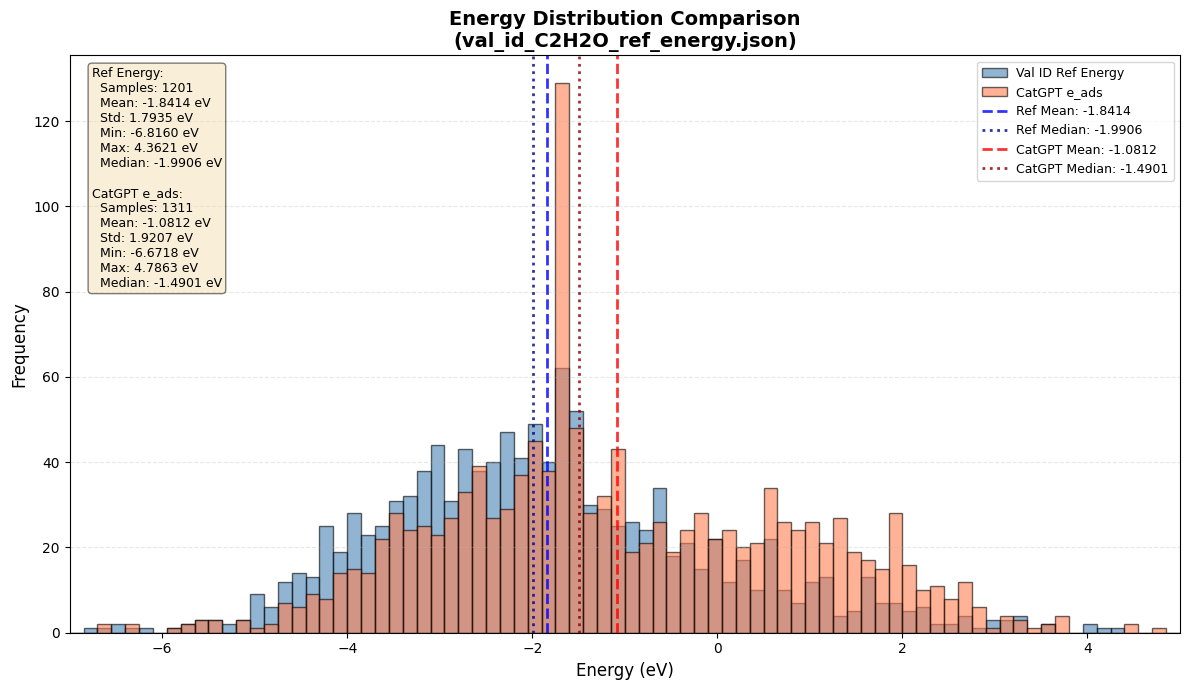


       Ref Energy Statistics       
Total samples: 1201
Mean: -1.8414 eV
Std: 1.7935 eV
Min: -6.8160 eV
Max: 4.3621 eV
Median: -1.9906 eV
Range: 11.1781 eV

       CatGPT e_ads Statistics       
Total samples: 1311
Mean: -1.0812 eV
Std: 1.9207 eV
Min: -6.6718 eV
Max: 4.7863 eV
Median: -1.4901 eV
Range: 11.4581 eV


In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

def plot_ref_energy_histogram(json_path, catgpt_json_path=None, bins=50, title=None):
    """
    JSON 파일에서 ref_energy 값을 읽어서 히스토그램을 그리는 함수
    catgpt_json_path가 제공되면 catgpt의 e_ads 값도 함께 그립니다.
    
    Args:
        json_path: ref_energy가 저장된 JSON 파일 경로
        catgpt_json_path: catgpt의 e_ads가 저장된 JSON 파일 경로 (선택사항)
        bins: 히스토그램 bin 개수
        title: 그래프 제목 (None이면 파일명에서 자동 생성)
    """
    # JSON 파일 로드
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # ref_energies 추출 (None 값 제거)
    ref_energies = [e for e in data['ref_energies'] if e is not None]
    
    if not ref_energies:
        print("No ref_energy values found in the JSON file.")
        return
    
    # catgpt의 e_ads 값 추출
    catgpt_energies = None
    if catgpt_json_path:
        try:
            with open(catgpt_json_path, 'r') as f:
                catgpt_data = json.load(f)
            # e_ads 값만 추출
            catgpt_energies = [item['e_ads'] for item in catgpt_data if 'e_ads' in item]
            print(f"Loaded {len(catgpt_energies)} e_ads values from catgpt.json")
        except Exception as e:
            print(f"Error loading catgpt.json: {e}")
            catgpt_energies = None
    
    # 에너지 범위 제한 (-7 ~ +5)
    energy_min, energy_max = -7, 5
    ref_energies_filtered = [e for e in ref_energies if energy_min <= e <= energy_max]
    print(f"Ref energy: {len(ref_energies)} -> {len(ref_energies_filtered)} (filtered: -7 <= E <= 5)")
    
    if catgpt_energies:
        catgpt_energies_filtered = [e for e in catgpt_energies if energy_min <= e <= energy_max]
        print(f"CatGPT e_ads: {len(catgpt_energies)} -> {len(catgpt_energies_filtered)} (filtered: -7 <= E <= 5)")
    else:
        catgpt_energies_filtered = None
    
    # 필터링된 값으로 업데이트
    ref_energies = ref_energies_filtered
    catgpt_energies = catgpt_energies_filtered
    
    # 통계 정보 계산 (ref_energy)
    energies_array = np.array(ref_energies)
    mean_energy = np.mean(energies_array)
    std_energy = np.std(energies_array)
    min_energy = np.min(energies_array)
    max_energy = np.max(energies_array)
    median_energy = np.median(energies_array)
    
    # catgpt 통계 정보 계산
    catgpt_mean = None
    catgpt_std = None
    catgpt_min = None
    catgpt_max = None
    catgpt_median = None
    if catgpt_energies:
        catgpt_array = np.array(catgpt_energies)
        catgpt_mean = np.mean(catgpt_array)
        catgpt_std = np.std(catgpt_array)
        catgpt_min = np.min(catgpt_array)
        catgpt_max = np.max(catgpt_array)
        catgpt_median = np.median(catgpt_array)
    
    # 제목 설정
    if title is None:
        title = f"Energy Distribution Comparison\n({json_path.split('/')[-1]})"
    
    # 히스토그램 그리기
    plt.figure(figsize=(12, 7))
    
    # 통일된 bins 계산 (두 데이터셋을 합쳐서 범위 계산)
    all_energies = ref_energies.copy()
    if catgpt_energies:
        all_energies.extend(catgpt_energies)
    
    # 범위 내에서 bins 계산
    _, unified_bins = np.histogram(all_energies, bins=bins, range=(energy_min, energy_max))
    
    # ref_energy histogram (통일된 bins 사용)
    n1, bins1, patches1 = plt.hist(ref_energies, bins=unified_bins, edgecolor='black', alpha=0.6, 
                                    color='steelblue', label='Val ID Ref Energy', density=False)
    
    # catgpt histogram (있는 경우, 통일된 bins 사용)
    if catgpt_energies:
        n2, bins2, patches2 = plt.hist(catgpt_energies, bins=unified_bins, edgecolor='black', alpha=0.6, 
                                       color='coral', label='CatGPT e_ads', density=False)
    
    # 평균과 중앙값 표시 (ref_energy)
    plt.axvline(mean_energy, color='blue', linestyle='--', linewidth=2, 
                label=f'Ref Mean: {mean_energy:.4f}', alpha=0.8)
    plt.axvline(median_energy, color='darkblue', linestyle=':', linewidth=2, 
                label=f'Ref Median: {median_energy:.4f}', alpha=0.8)
    
    # catgpt 평균과 중앙값 표시 (있는 경우)
    if catgpt_energies:
        plt.axvline(catgpt_mean, color='red', linestyle='--', linewidth=2, 
                    label=f'CatGPT Mean: {catgpt_mean:.4f}', alpha=0.8)
        plt.axvline(catgpt_median, color='darkred', linestyle=':', linewidth=2, 
                    label=f'CatGPT Median: {catgpt_median:.4f}', alpha=0.8)
    
    plt.xlabel('Energy (eV)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=9, loc='best')
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.xlim(-7, 5)  # 에너지 범위 제한
    
    # 통계 정보 텍스트 추가
    stats_text = 'Ref Energy:\n'
    stats_text += f'  Samples: {len(ref_energies)}\n'
    stats_text += f'  Mean: {mean_energy:.4f} eV\n'
    stats_text += f'  Std: {std_energy:.4f} eV\n'
    stats_text += f'  Min: {min_energy:.4f} eV\n'
    stats_text += f'  Max: {max_energy:.4f} eV\n'
    stats_text += f'  Median: {median_energy:.4f} eV'
    
    if catgpt_energies:
        stats_text += '\n\nCatGPT e_ads:\n'
        stats_text += f'  Samples: {len(catgpt_energies)}\n'
        stats_text += f'  Mean: {catgpt_mean:.4f} eV\n'
        stats_text += f'  Std: {catgpt_std:.4f} eV\n'
        stats_text += f'  Min: {catgpt_min:.4f} eV\n'
        stats_text += f'  Max: {catgpt_max:.4f} eV\n'
        stats_text += f'  Median: {catgpt_median:.4f} eV'
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    # 통계 정보 출력
    print(f"\n{'='*50}")
    print("       Ref Energy Statistics       ")
    print("="*50)
    print(f"Total samples: {len(ref_energies)}")
    print(f"Mean: {mean_energy:.4f} eV")
    print(f"Std: {std_energy:.4f} eV")
    print(f"Min: {min_energy:.4f} eV")
    print(f"Max: {max_energy:.4f} eV")
    print(f"Median: {median_energy:.4f} eV")
    print(f"Range: {max_energy - min_energy:.4f} eV")
    
    if catgpt_energies:
        print(f"\n{'='*50}")
        print("       CatGPT e_ads Statistics       ")
        print("="*50)
        print(f"Total samples: {len(catgpt_energies)}")
        print(f"Mean: {catgpt_mean:.4f} eV")
        print(f"Std: {catgpt_std:.4f} eV")
        print(f"Min: {catgpt_min:.4f} eV")
        print(f"Max: {catgpt_max:.4f} eV")
        print(f"Median: {catgpt_median:.4f} eV")
        print(f"Range: {catgpt_max - catgpt_min:.4f} eV")

# 실행
json_path = "val_id_C2H2O_ref_energy.json"
catgpt_json_path = "energies/C2H2O/catgpt.json"
plot_ref_energy_histogram(json_path, catgpt_json_path=catgpt_json_path, bins=80)


Loaded 1328 e_ads values from catgpt.json


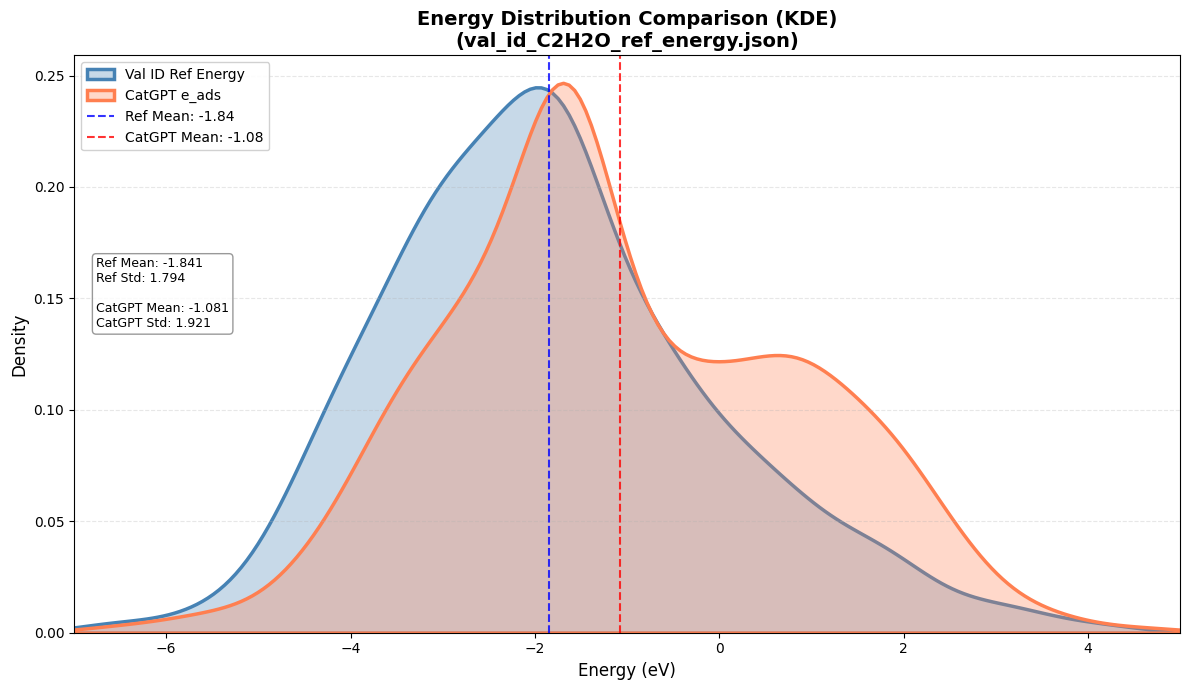

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # seaborn 추가

def plot_ref_energy_kde(json_path, catgpt_json_path=None, title=None):
    """
    JSON 파일에서 ref_energy 값을 읽어서 KDE(밀도 곡선)를 그리는 함수
    히스토그램보다 부드러운 곡선으로 표현하며, 테두리와 투명도를 적용하여 가시성을 높임
    """
    # JSON 파일 로드
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # ref_energies 추출
    ref_energies = [e for e in data['ref_energies'] if e is not None]
    
    # catgpt의 e_ads 값 추출
    catgpt_energies = None
    if catgpt_json_path:
        try:
            with open(catgpt_json_path, 'r') as f:
                catgpt_data = json.load(f)
            catgpt_energies = [item['e_ads'] for item in catgpt_data if 'e_ads' in item]
            print(f"Loaded {len(catgpt_energies)} e_ads values from catgpt.json")
        except Exception as e:
            print(f"Error loading catgpt.json: {e}")
            catgpt_energies = None
    
    # 에너지 범위 제한 (-7 ~ +5)
    energy_min, energy_max = -7, 5
    ref_energies_filtered = [e for e in ref_energies if energy_min <= e <= energy_max]
    
    if catgpt_energies:
        catgpt_energies_filtered = [e for e in catgpt_energies if energy_min <= e <= energy_max]
    else:
        catgpt_energies_filtered = None
    
    # 필터링된 값으로 업데이트
    ref_energies = ref_energies_filtered
    catgpt_energies = catgpt_energies_filtered
    
    # 통계 정보 계산 (그래프 표시용)
    mean_energy = np.mean(ref_energies)
    median_energy = np.median(ref_energies)
    
    if catgpt_energies:
        catgpt_mean = np.mean(catgpt_energies)
        catgpt_median = np.median(catgpt_energies)
    
    # 제목 설정
    if title is None:
        title = f"Energy Distribution Comparison (KDE)\n({json_path.split('/')[-1]})"
    
    # --- 그래프 그리기 ---
    plt.figure(figsize=(12, 7))
    
    # 1. Ref Energy KDE Plot
    # fill=True: 내부 채우기, alpha: 투명도, linewidth: 테두리 두께
    sns.kdeplot(ref_energies, 
                fill=True, color='steelblue', alpha=0.3, linewidth=2.5,
                label='Val ID Ref Energy', clip=(energy_min, energy_max), warn_singular=False)
    
    # 2. CatGPT KDE Plot (있는 경우)
    if catgpt_energies:
        sns.kdeplot(catgpt_energies, 
                    fill=True, color='coral', alpha=0.3, linewidth=2.5,
                    label='CatGPT e_ads', clip=(energy_min, energy_max), warn_singular=False)
    
    # 평균과 중앙값 표시 (Ref)
    plt.axvline(mean_energy, color='blue', linestyle='--', linewidth=1.5, 
                label=f'Ref Mean: {mean_energy:.2f}', alpha=0.8)
    # plt.axvline(median_energy, color='darkblue', linestyle=':', linewidth=1.5, label='Ref Median') # 너무 복잡하면 생략 가능
    
    # 평균과 중앙값 표시 (CatGPT)
    if catgpt_energies:
        plt.axvline(catgpt_mean, color='red', linestyle='--', linewidth=1.5, 
                    label=f'CatGPT Mean: {catgpt_mean:.2f}', alpha=0.8)

    plt.xlabel('Energy (eV)', fontsize=12)
    plt.ylabel('Density', fontsize=12) # KDE는 y축이 빈도가 아닌 밀도(Density)입니다
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=10, loc='upper left', frameon=True, framealpha=0.9)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.xlim(-7, 5)
    
    # 통계 박스 추가 (간략화)
    stats_text = f"Ref Mean: {mean_energy:.3f}\nRef Std: {np.std(ref_energies):.3f}"
    if catgpt_energies:
        stats_text += f"\n\nCatGPT Mean: {catgpt_mean:.3f}\nCatGPT Std: {np.std(catgpt_energies):.3f}"
        
    plt.text(0.02, 0.65, stats_text, transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'))
    
    plt.tight_layout()
    plt.show()

# 실행 예시
json_path = "val_id_C2H2O_ref_energy.json"
catgpt_json_path = "energies/C2H2O/catgpt.json"
plot_ref_energy_kde(json_path, catgpt_json_path=catgpt_json_path)